In [20]:
import os
import math
import numpy as np

from astropy.table import Table, column

import sys
sys.path.append('../astro_codes/')

% matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18

In [2]:
gz2_data = Table.read('fits/full_sample_debiased_w_low_z_mod.fits')

In [3]:
from luminosities_magnitudes_and_distances import mag_to_Mag

z_limits = (0.01,0.035)

in_z = np.all([gz2_data['REDSHIFT_1'] >= z_limits[0], gz2_data['REDSHIFT_1'] <= z_limits[1]],axis=0)

print('{} galaxies in {} < z < {}'.format(in_z.sum,*z_limits))

Mag_limit = mag_to_Mag(17,0.035)
in_Mag = gz2_data['PETROMAG_MR'] <= Mag_limit

print('=> {} galaxies in volume-limit'.format((in_z*in_Mag).sum()))

galaxy_ok = gz2_data['t01_smooth_or_features_a03_star_or_artifact_debiased_rh'] < 0.5
print('=> {} galaxies are not artefacts'.format((in_z*in_Mag*galaxy_ok).sum()))

in_sample = np.all([in_z,in_Mag,galaxy_ok],axis=0)

<built-in method sum of numpy.ndarray object at 0x106b16490> galaxies in 0.01 < z < 0.035
=> 22793 galaxies in volume-limit
=> 22787 galaxies are not artefacts


In [4]:
f_features = gz2_data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
f_face_on = gz2_data['t02_edgeon_a05_no_debiased_rh']
f_spiral = gz2_data['t04_spiral_a08_spiral_debiased_rh']

in_disc = np.all([f_features*f_face_on >= 0.5,gz2_data['t02_edgeon_a05_no_count'] >= 5],axis=0)
in_spiral = np.all([f_features*f_face_on*f_spiral >= 0.5,gz2_data['t04_spiral_a08_spiral_count'] >= 5],axis=0)
print('{} discs + {} spirals'.format((in_sample*in_disc).sum(),(in_sample*in_spiral).sum()))

disc_sample = np.all([in_sample,in_disc],axis=0)
spiral_sample = np.all([in_sample,in_spiral],axis=0)

8481 discs + 5847 spirals


/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater_equal
/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: invalid value encountered in greater_equal


#### First task: GZ2 data vs. sparcfire

In [5]:
sparcfire_data = Table.read('fits/sparcfire_fits/arc_table_all.fits')

def measure_N_detected(ids,arc_data):
    N_good = []
    pitch_angles = []
    for id_ in ids:
        arc_row_mask = arc_data['gxyName'] == id_
        N_total_id = arc_row_mask.sum()
        if N_total_id > 0:
            arcs_id = arc_data[arc_row_mask]
            good_arcs = arcs_id['p_good_predicted'] == 1
            N_good_id = good_arcs.sum()
            if N_good_id > 0:
                length_weights = arcs_id['arc_length'][good_arcs]
                Ps = arcs_id['pitch_angle_absolute'][good_arcs]
                pitch_angle = np.average(Ps,weights=length_weights)
            else:
                pitch_angle = -999
            
            N_good.append(N_good_id)
            pitch_angles.append(pitch_angle)
        else:
            N_good.append(-999)
            pitch_angles.append(-999)
    
    return np.array(N_good), np.array(pitch_angles)

dr8ids = gz2_data['dr8objid']
Ns, psis = measure_N_detected(dr8ids,sparcfire_data)


psi_data = Table()
psi_data['id'] = dr8ids
psi_data['N'] = Ns
psi_data['psi'] = psis

psi_data.write('fits/galaxy_level_all.fits',overwrite=True)

2365 galaxies have sparcfire arcs in GZ2
y=10.95x + 14.73


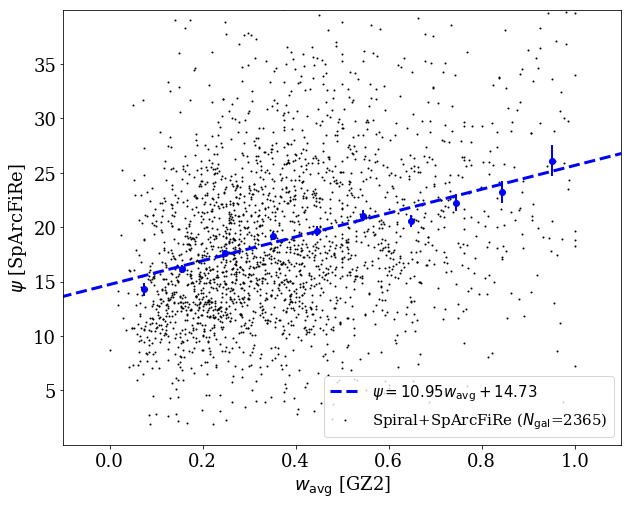

In [6]:
from xy_plots import x_vs_y
from contours import kde_contour
from scipy.optimize import curve_fit

def linear(x,m,c):
    return m*x + c

psi = psi_data['psi']
in_sparcfire = psi >= 0
spiral_sparcfire = np.all([spiral_sample,in_sparcfire],axis=0)
print('{} galaxies have sparcfire arcs in GZ2'.format(spiral_sparcfire.sum()))

w_avg = (0*gz2_data['t10_arms_winding_a28_tight_debiased_rh']
     + 0.5*gz2_data['t10_arms_winding_a29_medium_debiased_rh']
     + 1*gz2_data['t10_arms_winding_a30_loose_debiased_rh'])

fig = plt.figure()
ax = plt.subplot(111)
_ = ax.set_xlabel('$w_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$\psi$ [SpArcFiRe]')
_ = ax.set_xlim(-0.1,1.1)
_ = ax.set_ylim(0,40)

x = w_avg[spiral_sparcfire]
y = psi[spiral_sparcfire]

scatter_label = 'Spiral+SpArcFiRe ($N_\mathrm{{gal}}$={})'.format(len(x))
_ = plt.scatter(x,y,color='k',s=1,rasterized=True,zorder=0,
                label=scatter_label)
#_ = kde_contour(x,y,fill=True,zorder=1)

xy = x_vs_y(x,y)
xy = xy.continuous_vs_continuous_binned_mean()
xy.error_plot(ax,style='errorbar',fmt='o',lw=2,color='blue',capthick=2)

x_guide = np.linspace(-1,2,100)
p_psi, _ = curve_fit(linear,x,y)
print('y={}x + {}'.format(*np.round(p_psi,decimals=2)))
line_label = '$\psi={}w_\mathrm{{avg}} + {}$'.format(*np.round(p_psi,decimals=2))
_ = plt.plot(x_guide,linear(x_guide,*p_psi),
             color='blue',lw=3,linestyle='dashed',zorder=2,
             label=line_label)

_ = ax.legend(fontsize=15)

#### Next: GZ2 data vs. Simard+11 bulge fraction

In [7]:
from combining_catalogues import match_ids, make_matched_catalogue

simard_data = Table.read('fits/simard11.fits')
ids_ = match_ids(gz2_data,simard_data,'dr7objid','objID')
simard_matched = make_matched_catalogue(gz2_data,simard_data,ids_)
simard_matched['dr7objid'] = gz2_data['dr7objid']

simard_matched.write('fits/simard_matched.fits',overwrite=True)

248883 galaxies in the reference catalogue
1123718 galaxies in the match catalogue
---> 245259 matches in total


In [8]:
from luminosities_magnitudes_and_distances import Mag_to_lum, lum_to_solar
L_r = lum_to_solar(Mag_to_lum(np.array(gz2_data['PETROMAG_MR'],dtype='float64'),6185.19))

In [9]:
from scipy.stats import spearmanr

btr = simard_matched['__B_T_r']
in_simard = np.all([simard_matched['__B_T_r'] >= 0, simard_matched['__B_T_r'] <= 1],axis=0)
disc_simard = np.all([disc_sample,in_simard],axis=0)
print('{} galaxies have BTRs in GZ2'.format(disc_simard.sum()))

B_avg = (0*gz2_data['t05_bulge_prominence_a10_no_bulge_debiased_rh']
     + 0.2*gz2_data['t05_bulge_prominence_a11_just_noticeable_debiased_rh']
     + 0.8*gz2_data['t05_bulge_prominence_a12_obvious_debiased_rh']
     + 1.0*gz2_data['t05_bulge_prominence_a13_dominant_debiased_rh'])
'''
fig = plt.figure()
ax = plt.subplot(111)
_ = ax.set_xlabel('$B_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$(B/T)_r$ [Simard+11]')
#_ = ax.set_xlim(0.75,3.25)
#_ = ax.set_ylim(0,40)

x = B_avg[disc_simard]
y = btr[disc_simard]

scatter_label = 'Disc+Simard ($N_\mathrm{{gal}}$={})'.format(len(x))
_ = plt.scatter(x,y,color='k',s=1,rasterized=True,zorder=0,
                label=scatter_label)
#_ = kde_contour(x,y,fill=True,zorder=1)

xy = x_vs_y(x,y)
xy = xy.continuous_vs_continuous_binned_mean()
xy.error_plot(ax,style='errorbar',fmt='o',lw=2,color='red',capthick=2)

x_guide = np.linspace(-1,5,100)
p_btr, _ = curve_fit(linear,x,y)
print('y={}x + {}'.format(*np.round(p_btr,decimals=2)))
line_label = '$(B/T)_r={}B_\mathrm{{avg}} + {}$'.format(*np.round(p_psi,decimals=2))
_ = plt.plot(x_guide,linear(x_guide,*p_btr),
             color='red',lw=3,linestyle='dashed',zorder=2,
             label=line_label)

print(spearmanr(x,y))

_ = ax.legend(fontsize=15)
'''

7078 galaxies have BTRs in GZ2


/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater_equal
/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in less_equal


"\nfig = plt.figure()\nax = plt.subplot(111)\n_ = ax.set_xlabel('$B_\\mathrm{avg}$ [GZ2]')\n_ = ax.set_ylabel('$(B/T)_r$ [Simard+11]')\n#_ = ax.set_xlim(0.75,3.25)\n#_ = ax.set_ylim(0,40)\n\nx = B_avg[disc_simard]\ny = btr[disc_simard]\n\nscatter_label = 'Disc+Simard ($N_\\mathrm{{gal}}$={})'.format(len(x))\n_ = plt.scatter(x,y,color='k',s=1,rasterized=True,zorder=0,\n                label=scatter_label)\n#_ = kde_contour(x,y,fill=True,zorder=1)\n\nxy = x_vs_y(x,y)\nxy = xy.continuous_vs_continuous_binned_mean()\nxy.error_plot(ax,style='errorbar',fmt='o',lw=2,color='red',capthick=2)\n\nx_guide = np.linspace(-1,5,100)\np_btr, _ = curve_fit(linear,x,y)\nprint('y={}x + {}'.format(*np.round(p_btr,decimals=2)))\nline_label = '$(B/T)_r={}B_\\mathrm{{avg}} + {}$'.format(*np.round(p_psi,decimals=2))\n_ = plt.plot(x_guide,linear(x_guide,*p_btr),\n             color='red',lw=3,linestyle='dashed',zorder=2,\n             label=line_label)\n\nprint(spearmanr(x,y))\n\n_ = ax.legend(fontsize=15)\n"

6887 galaxies have BTRs in GZ2
y=1.54x + 8.63
(0.51837526260748956, 0.0)


/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from IPython.kernel.zmq import kernelapp as app
/Users/rosshart/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from IPython.kernel.zmq import kernelapp as app


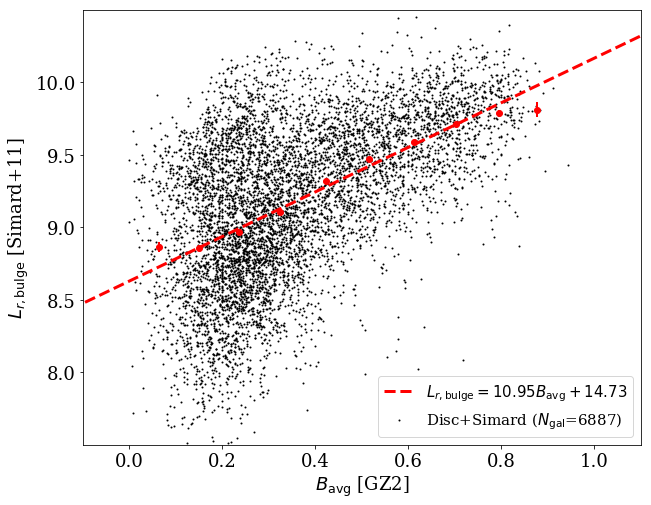

In [10]:
L_bulge = np.log10(simard_matched['__B_T_r'] * 10**(L_r))
in_simard = np.all([simard_matched['__B_T_r'] > 0, simard_matched['__B_T_r'] <= 1],axis=0)
disc_simard = np.all([disc_sample,in_simard],axis=0)
print('{} galaxies have BTRs in GZ2'.format(disc_simard.sum()))

fig = plt.figure()
ax = plt.subplot(111)
_ = ax.set_xlabel('$B_\mathrm{avg}$ [GZ2]')
_ = ax.set_ylabel('$L_{r,\mathrm{bulge}}$ [Simard+11]')
_ = ax.set_xlim(-0.1,1.1)
_ = ax.set_ylim(7.5,10.5)

x = B_avg[disc_simard]
y = L_bulge[disc_simard]

scatter_label = 'Disc+Simard ($N_\mathrm{{gal}}$={})'.format(len(x))
_ = plt.scatter(x,y,color='k',s=1,rasterized=True,zorder=0,
                label=scatter_label)
#_ = kde_contour(x,y,fill=True,zorder=1)

xy = x_vs_y(x,y)
xy = xy.continuous_vs_continuous_binned_mean()
xy.error_plot(ax,style='errorbar',fmt='o',lw=2,color='red',capthick=2)

x_guide = np.linspace(-1,5,100)
p_btr, _ = curve_fit(linear,x,y)
print('y={}x + {}'.format(*np.round(p_btr,decimals=2)))
line_label = '$L_{{r,\mathrm{{bulge}}}}={}B_\mathrm{{avg}} + {}$'.format(*np.round(p_psi,decimals=2))
_ = plt.plot(x_guide,linear(x_guide,*p_btr),
             color='red',lw=3,linestyle='dashed',zorder=2,
             label=line_label)

print(spearmanr(x,y))

_ = ax.legend(fontsize=15)

In [18]:
def fit_plotter(ax,x,y,xlabel='x',ylabel='y',sample_label='sample',ylims=(0,40),
                shortlabels='xy',color='b'):
    plt.sca(ax)
    _ = ax.set_xlabel(xlabel)
    _ = ax.set_ylabel(ylabel)
    _ = ax.set_xlim(-0.1,1.1)
    _ = ax.set_ylim(ylims)
    
    scatter_label = '{} ($N_\mathrm{{gal}}$={})'.format(sample_label,len(x))
    _ = ax.scatter(x,y,color='k',s=2,rasterized=True,zorder=0,
                label=scatter_label)
    _ = kde_contour(x,y,fill=True,zorder=1)
    xy = x_vs_y(x,y)
    xy = xy.continuous_vs_continuous_binned_mean()
    xy.error_plot(ax,style='errorbar',fmt='o',lw=2,color=color,capthick=2,zorder=3,capsize=3)

    x_guide = np.linspace(-1,2,100)
    p_fit, _ = curve_fit(linear,x,y)
    line_label = '${}={}{} + {}$'.format(shortlabels[0],np.round(p_fit[0],decimals=2),
                                         shortlabels[1],np.round(p_fit[1],decimals=2))
    _ = ax.plot(x_guide,linear(x_guide,*p_fit),
                color=color,lw=3,linestyle='dashed',zorder=2,
                label=line_label)

    _ = ax.legend(fontsize=15,loc='lower right')
    return None

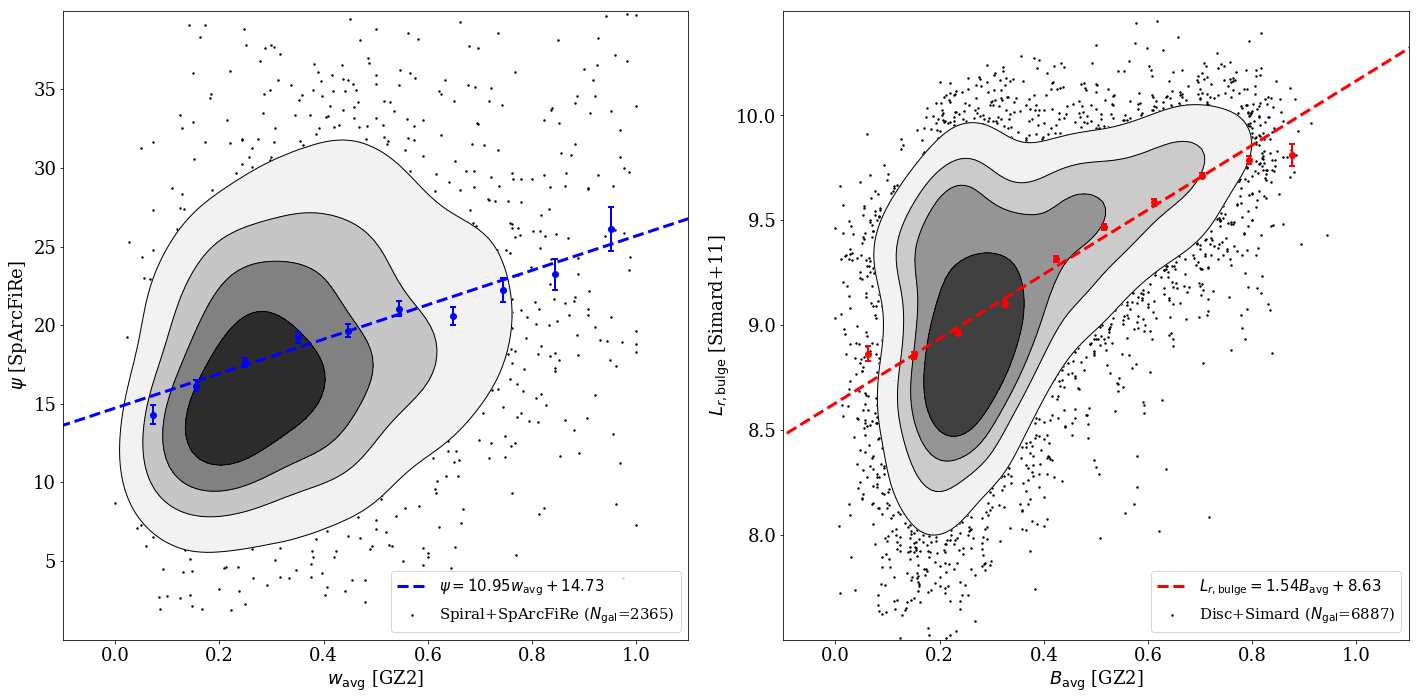

In [22]:
fig, axarr = plt.subplots(1,2,figsize=(20,10))

ax = axarr[0]
x = w_avg[spiral_sparcfire]
y = psi[spiral_sparcfire]
fit_plotter(ax,x,y,'$w_\mathrm{avg}$ [GZ2]','$\psi$ [SpArcFiRe]','Spiral+SpArcFiRe',(0,40),
            ('\psi','w_\mathrm{{avg}}'),color='b')

ax = axarr[1]
x = B_avg[disc_simard]
y = L_bulge[disc_simard]
fit_plotter(ax,x,y,'$B_\mathrm{avg}$ [GZ2]','$L_{r,\mathrm{bulge}}$ [Simard+11]','Disc+Simard',(7.5,10.5),
           ('L_{r,\mathrm{{bulge}}}','B_\mathrm{{avg}}'),color='r')

fig.tight_layout()

fig.savefig('figures/gz2_vs_psi_and_bulge.pdf')